# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Импортируем нужные библиотеки:

In [1]:
import pandas as pd # импорт библиотеки pandas 
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
import numpy as np # импорт библиотеки nump
from scipy import stats as st # импорт библиотеки scipy
import random

from sklearn.metrics import accuracy_score # импорт метрики из библиотеки sklearn 
from sklearn.model_selection import train_test_split # импорт разделителя
from sklearn.tree import DecisionTreeClassifier # импорт дерева решений
from sklearn.ensemble import RandomForestClassifier # импорт классификатора случайного леса
from sklearn.linear_model import LogisticRegression # импорт линейной регрессии 
from catboost import CatBoostClassifier, Pool # импорт классификатора библиотеки CatBoost

from sklearn.dummy import DummyClassifier # испорт Dummy для проверки адекватности

import time
from tqdm import tqdm # импорт библиотеки tqdm для просмотра прогресса обучения модели

Изучим базу данных:

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Проверим дубликаты:

In [5]:
df.duplicated().sum()

0

Посмотрим на выбросы с помощью boxplot:

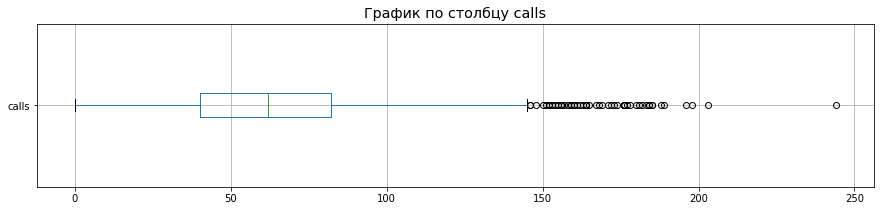

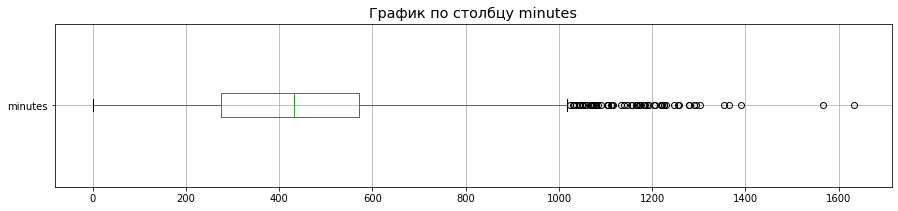

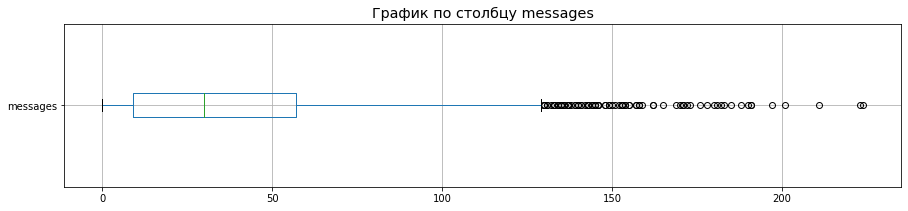

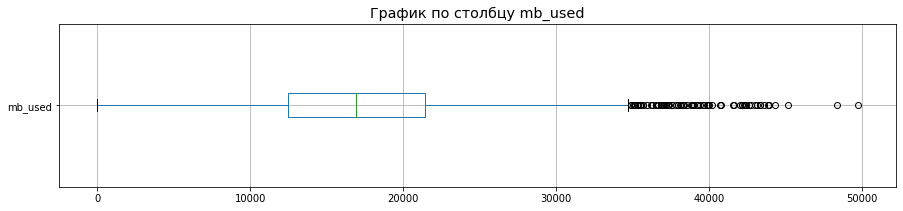

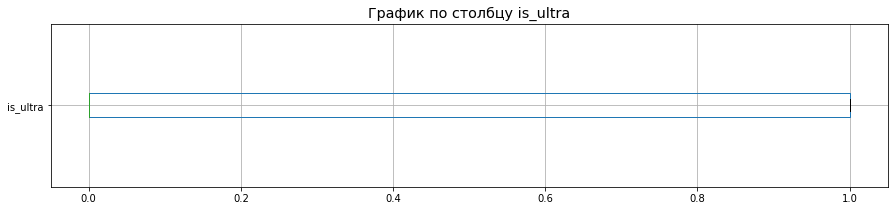

In [6]:
for col in df.columns:
    plt.figure(figsize=(15,3))
    df.boxplot(col, vert=False)
    plt.title(f'График по столбцу {col}', fontsize='x-large')
    plt.show()

Построим гистограммы значений по каждому столбцу:

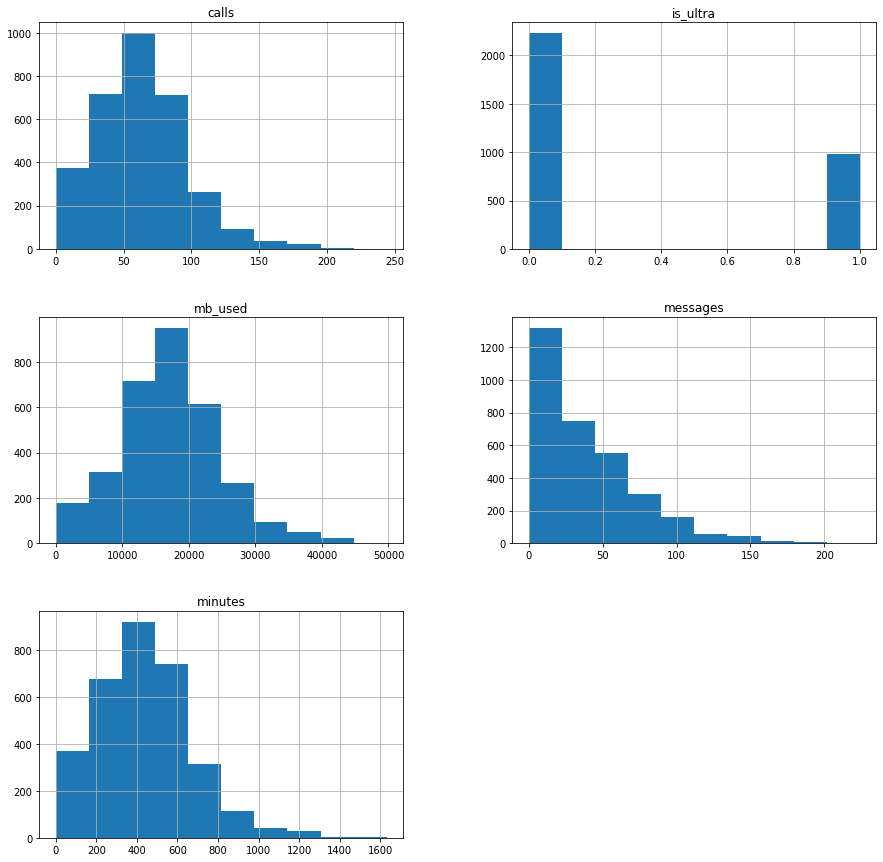

In [7]:
df.hist(figsize=(15,15))
plt.show()

### Вывод:

* Количество строк в базе данных - `3214`
* Количество пользователей smart и ultra отличается, нужно будет учесть в разделении выборок
* Дубликатов и пустых значений нет

## Разбейте данные на выборки

Какую часть данных отвести под валидационную выборку, решают в зависимости от количества объектов, признаков и вариативности
данных. Вот два самых распространённых сценария:

1. Доступен исходный датасет, а тестовая выборка спрятана. Тогда рекомендуется 75% данных отвести под обучающую, а 25% — под валидационную. Соотношение 3:1.
2. Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

Воспользуемся вторым методом, так как тестовой выборки нет.

**Выведем нужные нам столбцы и и присвоим их к новым переменным:**

In [8]:
df_features = df.drop('is_ultra', axis=1) # датасет без target 
df_target = df['is_ultra'] # target 

Разделим выборки:

> По ранее полученным графикам видно, что количество пользователей `smart` и `ultra` отличается, значит, воспользуемся стратификацией, для более точных предсказаний

In [9]:
# воспользуемся train_test_split с стратификацией по target

df_f_train, df_f_test, df_t_train, df_t_test = train_test_split(df_features,
                                                                df_target,
                                                                test_size=0.2,
                                                                random_state=12345, 
                                                                stratify=df_target)

In [10]:
# воспользуемся train_test_split с стратификацией по target

df_f_train, df_f_valid, df_t_train, df_t_valid = train_test_split(df_f_train,
                                                                df_t_train,
                                                                test_size=0.25,
                                                                random_state=12345, 
                                                                stratify=df_t_train)

### Вывод

Данные разделены, можно приступать к исследованию моделей.

## Исследуйте модели

Для машинного обучения на тренировочной выборке воспользуемся ранее изученными способами классификации:

1. Дерево решений
2. Случайный лес
3. Линейная регрессия

И так же подберём гиперпараметры на валидацонной выборке.

И для эксперимента продолжим исследование на одной из популярных моделей, ранее не изученных мной, градиентного бустинга: `CatBoost` 

Для метрики качества воспользуемся функцией `accuracy`, так как она предназначена для задач классификации.

### Дерево решений

Рассмотрим одну популярную модель — решающее дерево. Оно может описывать процесс принятия решения почти в любой ситуации. На основе значений признаков формулируются ответы, а затем выстраивается дерево с ответами «Да»/«Нет» и различными вариантами действий

Для сравнения гиперпараметров, создадим отдельную таблицу, где будем смотреть наши параметры и точность:

In [11]:
table_tree = pd.DataFrame({'max_depth':[], 'accuracy':[]})

In [12]:
# запустим цикл с перебором глубины дерева от 1 до 10

for depth in tqdm(range(1, 11)):
    row = [] # строка для заполнения таблицы
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # задаём параметры
    model.fit(df_f_train, df_t_train) # учим модель 
    predictions_valid = model.predict(df_f_valid) # предсказываем
    accuracy = accuracy_score(df_t_valid, predictions_valid) # смотрим точность
    row.extend([depth, accuracy]) # добавляем к строке данные
    table_tree.loc[len(table_tree.index)] = row # заполняем таблицу

100%|██████████| 10/10 [00:00<00:00, 93.49it/s]


**Результат:**

In [13]:
table_tree

,max_depth,accuracy
0,1.0,0.758942
1,2.0,0.783826
2,3.0,0.804044
3,4.0,0.804044
4,5.0,0.816485
5,6.0,0.802488
6,7.0,0.807154
7,8.0,0.805599
8,9.0,0.811820
9,10.0,0.805599


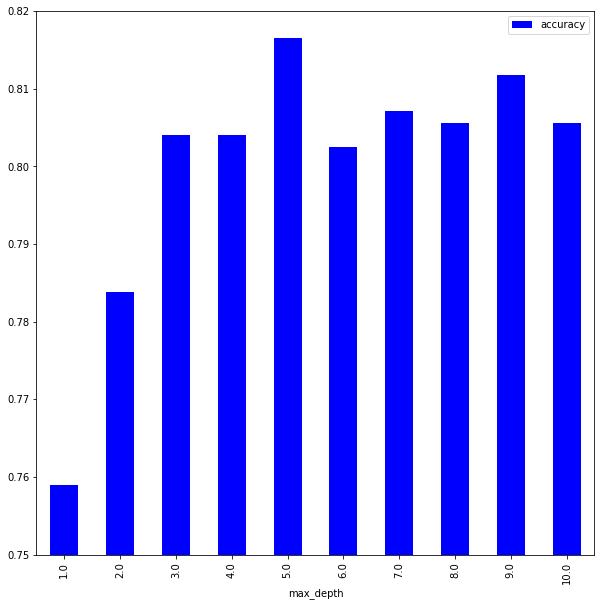

In [14]:
# посмотрим график

table_tree.plot.bar(x='max_depth', y='accuracy', ylim=(0.75, 0.82), figsize=(10,10), color='blue')
plt.show()

Максимальная точность получилась при глубине - `5`, сохраним наш результат:

In [15]:
best_tree = table_tree[table_tree['accuracy'] == table_tree['accuracy'].max()]

best_tree['model'] = ['decision tree']

best_tree

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,max_depth,accuracy,model
4,5.0,0.816485,decision tree


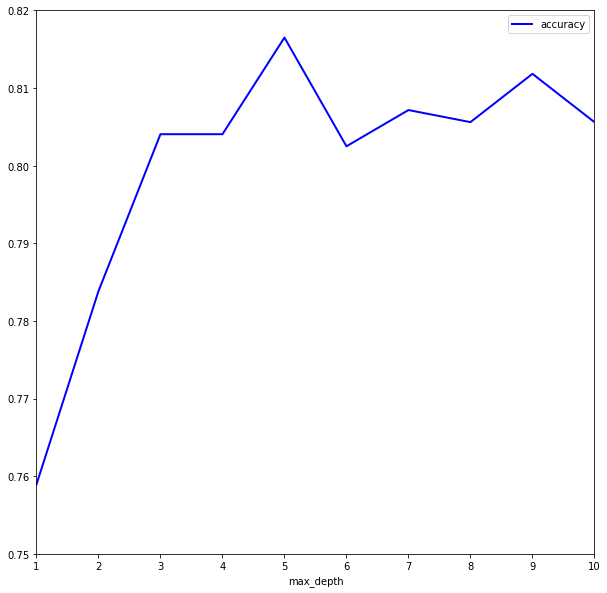

In [42]:
table_tree.plot(x='max_depth', y='accuracy', ylim=(0.75, 0.82), figsize=(10,10), color='blue', lw=2)
plt.show()

### Случайный лес

Один из алгоритмов классификации — случайный лес (random forest). Алгоритм обучает большое количество независимых друг от друга
деревьев, а потом принимает решение на основе голосования

Для сравнения гиперпараметров, создадим отдельную таблицу, где будем смотреть наши параметры и точность:

In [16]:
table_forest = pd.DataFrame({'n_estimators':[], 'max_depth':[], 'accuracy':[]})

In [17]:
# запустим цикл с перебором количества деревьев от 10 до 50 с шагом 10
# и глубины дерева от 1 до 10

for est in tqdm(range(10, 51, 10)):
    for depth in range (1, 11):
        row = []
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(df_f_train, df_t_train)
        predictions_valid = model.predict(df_f_valid)
        accuracy = accuracy_score(df_t_valid, predictions_valid)
        row.extend([est, depth, accuracy])
        table_forest.loc[len(table_forest.index)] = row

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


**Результат:**

In [18]:
table_forest.head(10)

,n_estimators,max_depth,accuracy
0,10.0,1.0,0.751166
1,10.0,2.0,0.782271
2,10.0,3.0,0.793157
3,10.0,4.0,0.821151
4,10.0,5.0,0.814930
5,10.0,6.0,0.814930
6,10.0,7.0,0.819596
7,10.0,8.0,0.832037
8,10.0,9.0,0.821151
9,10.0,10.0,0.810264


Для простоты визуализации зададим функцию, которая подберет случайный цвет для графика в формате RGBA

In [19]:
def random_color():
    color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    return color

Рассмотрим графики:

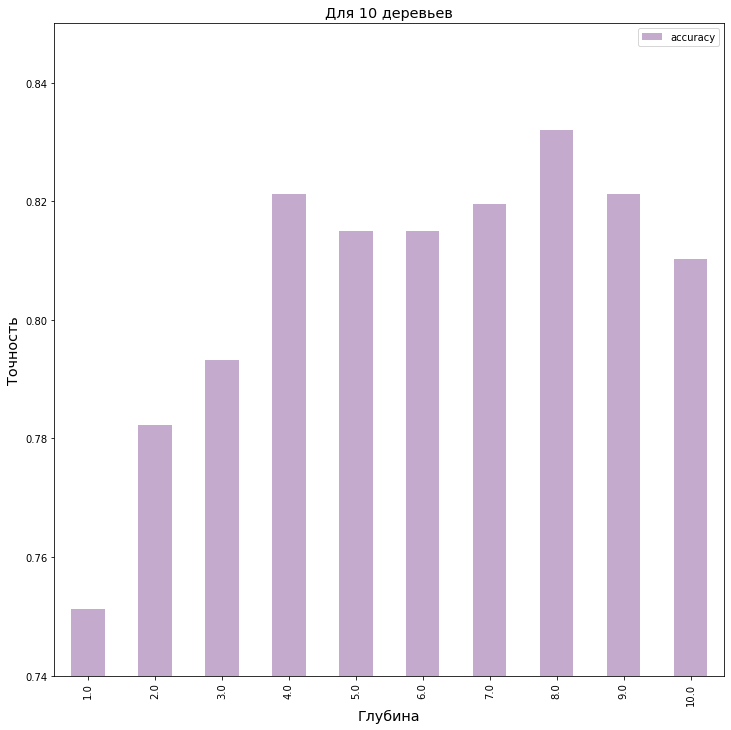

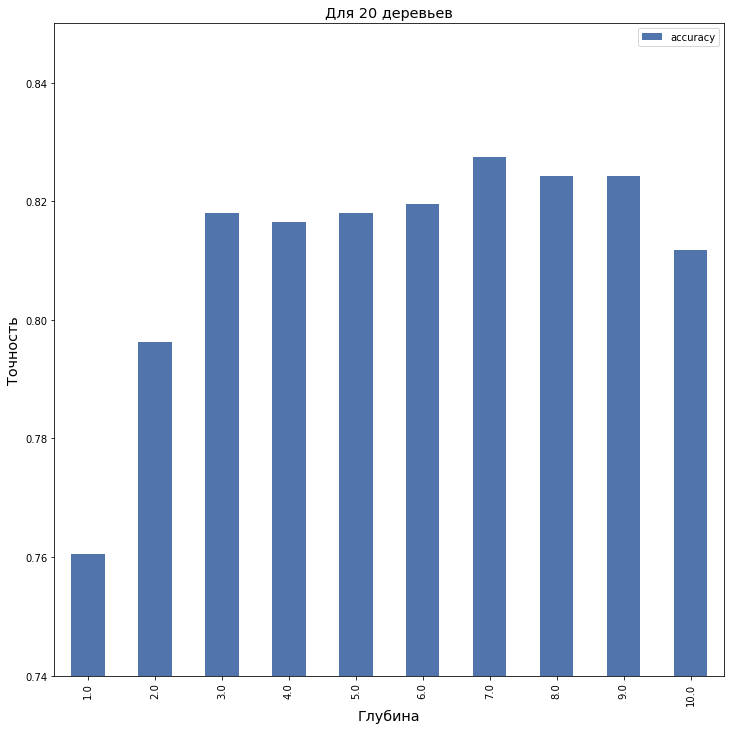

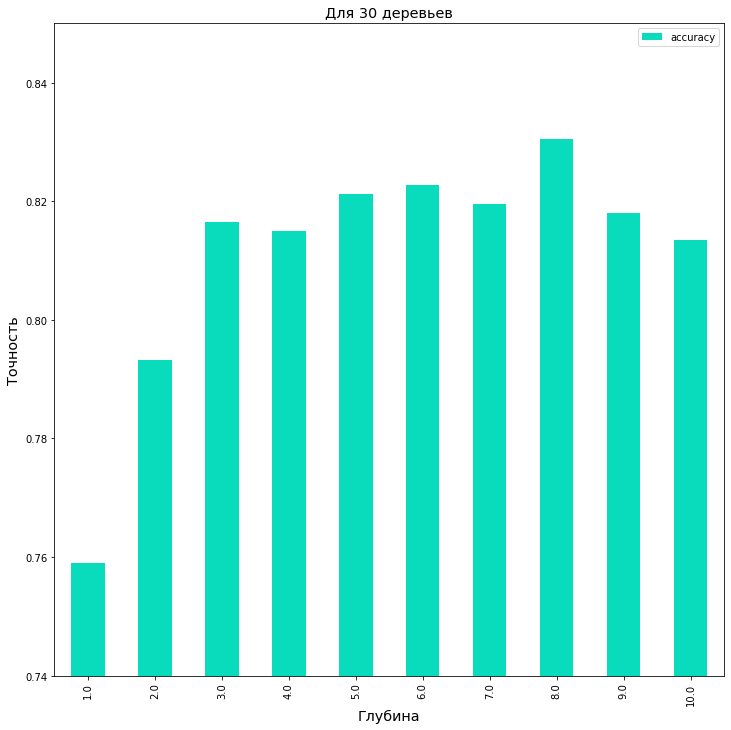

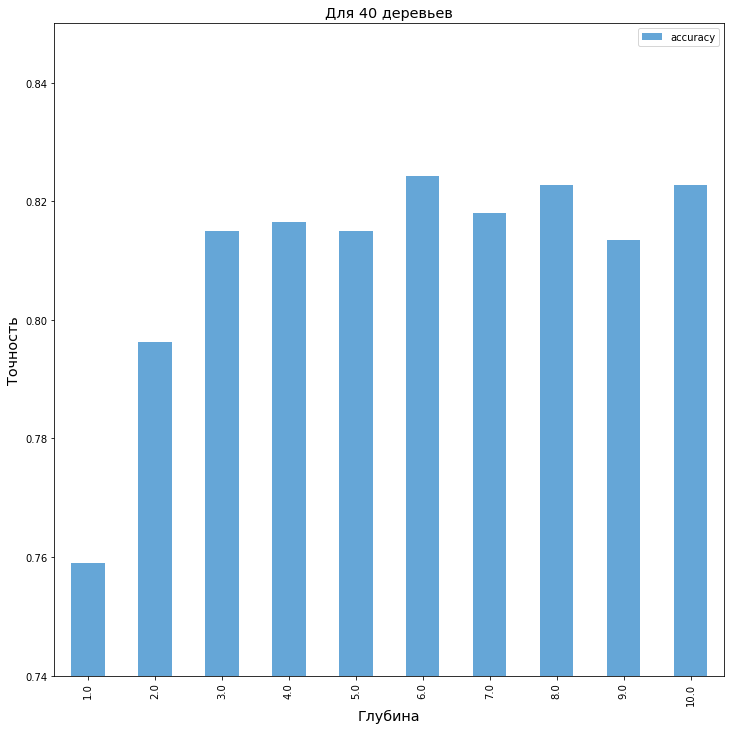

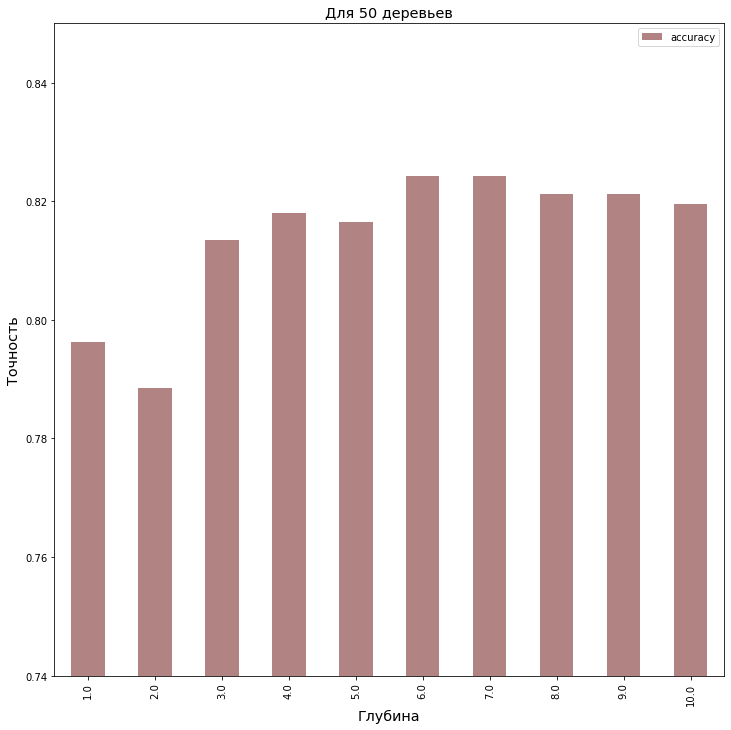

In [20]:
for est in range(10, 51, 10):
    table_forest
    table_forest[table_forest['n_estimators'] == est].plot.bar(x='max_depth', 
                                                               y='accuracy', 
                                                               ylim=(0.74, 0.85), 
                                                               figsize=(12,12), 
                                                               color=random_color())
    plt.ylabel('Точность', fontsize='x-large')
    plt.xlabel('Глубина', fontsize='x-large')
    plt.title(f'Для {est} деревьев', fontsize='x-large')
    plt.show()

Максимальная точность получилась:
* при количестве - `10`
* при глубине - `8`.

Сохраним наш результат:

In [21]:
best_forest = table_forest[table_forest['accuracy'] == table_forest['accuracy'].max()]

best_forest['model'] = 'random forest'

best_forest

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,n_estimators,max_depth,accuracy,model
7,10.0,8.0,0.832037,random forest


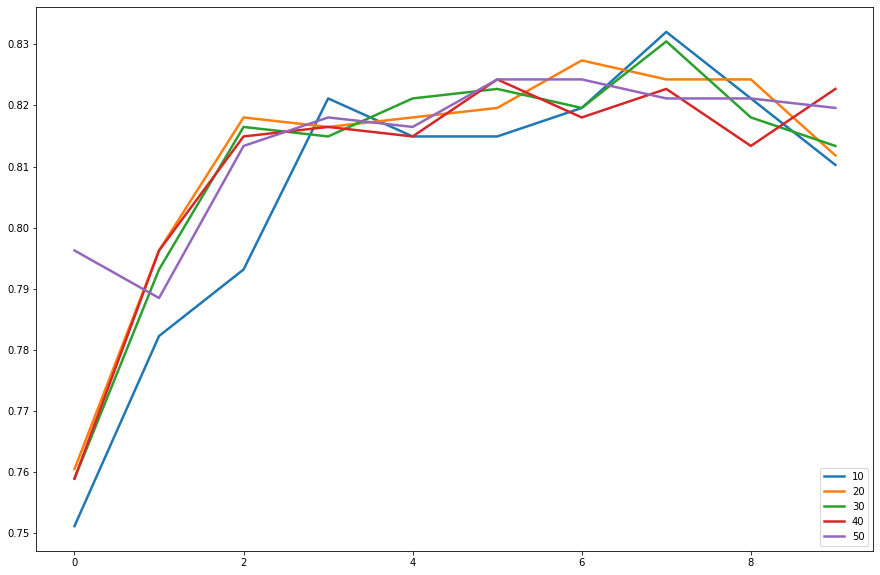

In [93]:
fig, ax1 = plt.subplots(figsize=(15,10))

for est in range(10, 51, 10):
    table_pivot = table_forest[table_forest['n_estimators'] == est].reset_index()
    ax1.plot(table_pivot.index, 'accuracy', data=table_pivot, lw=2.5, label=est)
    plt.legend(loc='lower right')

plt.show()

### Логистическая регрессия

Ещё один алгоритм машинного обучения — логистическая регрессия.

Если название и «мимикрирует» под задачу регрессии, всё-таки это алгоритм классификации. Логистическая регрессия:
* Сначала считает, к какому классу близок объект
* В зависимости от ответа выбирает нужный класс: если результат вычисления положительный, то — «1»; отрицательный — «0».

В логистической регрессии параметров мало. Что-либо вызубрить по признакам в формуле не выйдет, поэтому и вероятность переобучения невелика.

In [22]:
# запустим модель и посмотрим результат

model_log = LogisticRegression(random_state=12345)
model_log.fit(df_f_train, df_t_train)
answers_log = model_log.predict(df_f_valid)
accuracy_log = accuracy_score(df_t_valid, answers_log)

accuracy_log

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7045101088646968

Сохраним результат:

In [23]:
table_log = pd.DataFrame({'model': ['logistic regression'], 'accuracy': accuracy_log})

table_log

,model,accuracy
0,logistic regression,0.70451


Точность при использовании логистической регрессии низкая для поставленной нам цели: всего лишь `0.70451`.

Соответственно, не будем рассматривать далее этот способ на тестовой выборке.

### CatBoost (Градиентный бустинг)

В градиентном бустинге прогнозы делаются на основе ансамбля слабых обучающих алгоритмов. В отличие от случайного леса, который создает дерево решений для каждой выборки, в градиентном бустинге деревья создаются последовательно. Предыдущие деревья в модели не изменяются. Результаты предыдущего дерева используются для улучшения последующего. 

`CatBoost` — это библиотека градиентного бустинга, созданная Яндексом. Она использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (split) на каждом уровне дерева.

In [24]:
# создаём таблицу для записи решений

table_cat = pd.DataFrame({'iterations':[], 'max_depth':[], 'accuracy':[]})

In [25]:
# запустим цикл с перебором количества деревьев от 100 до 1000 с шагом 100
# и глубины дерева от 6 до 11 (на основании рекомндаций в документации)

for it in tqdm(range(100, 1001, 100)):
    for depth in range(6, 11):
        row = []
        model = CatBoostClassifier(random_state=12345, iterations=it, max_depth=depth) # 
        model.fit(df_f_train, df_t_train, verbose=False) # обучите модель на тренировочной выборке
        predictions_valid = model.predict(df_f_valid) # получите предсказания модели на валидационной выборке
        accuracy = accuracy_score(df_t_valid, predictions_valid)
        row.extend([it, depth, accuracy])
        table_cat.loc[len(table_cat.index)] = row

100%|██████████| 10/10 [12:31<00:00, 75.11s/it] 


**Результат:**

In [26]:
table_cat.head()

,iterations,max_depth,accuracy
0,100.0,6.0,0.821151
1,100.0,7.0,0.827372
2,100.0,8.0,0.816485
3,100.0,9.0,0.822706
4,100.0,10.0,0.825816


Рассмотрим графики:

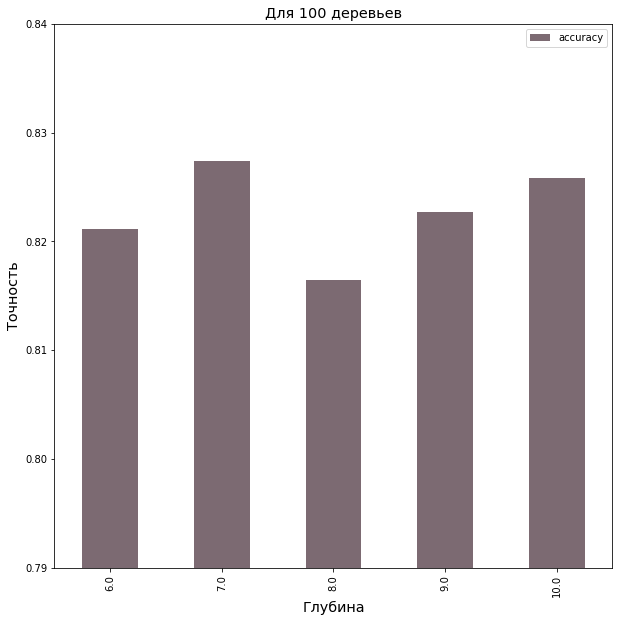

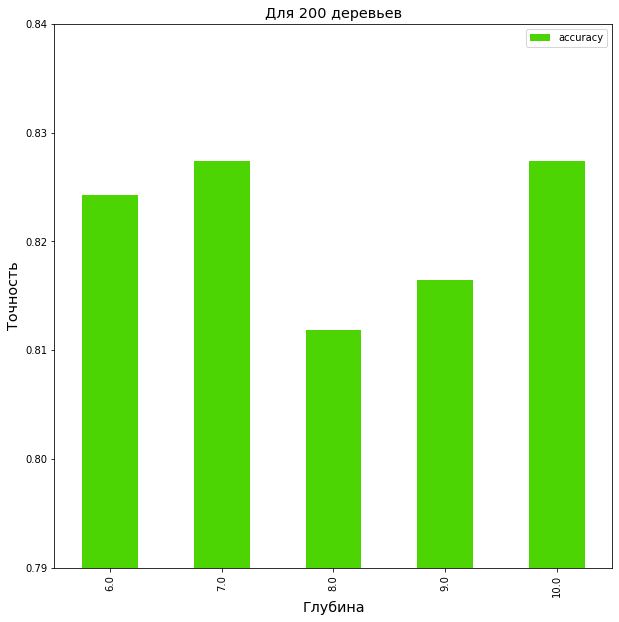

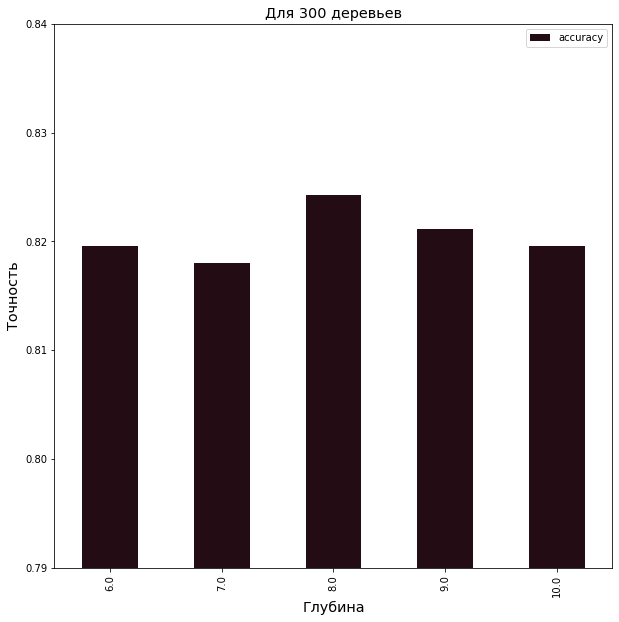

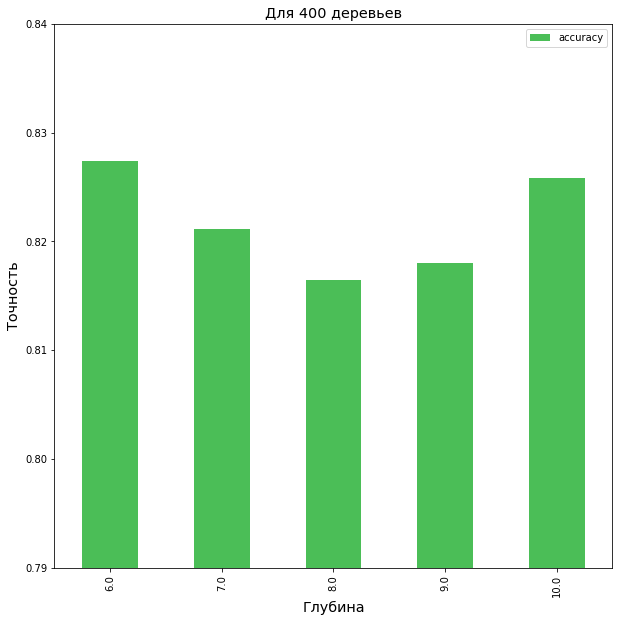

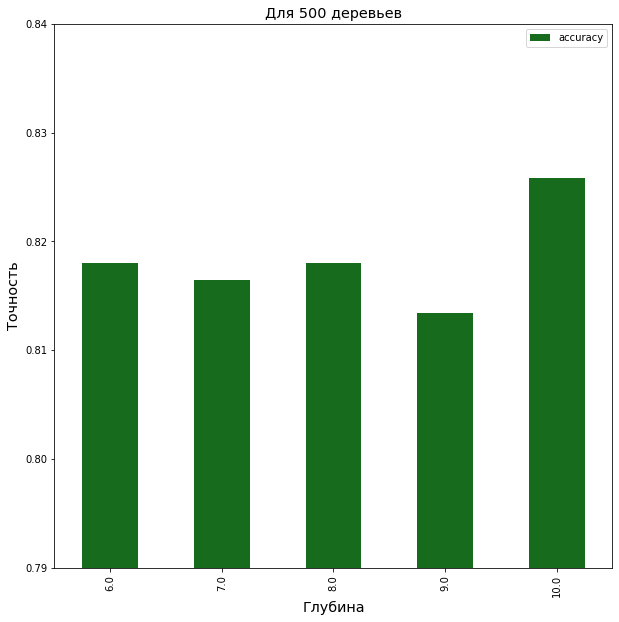

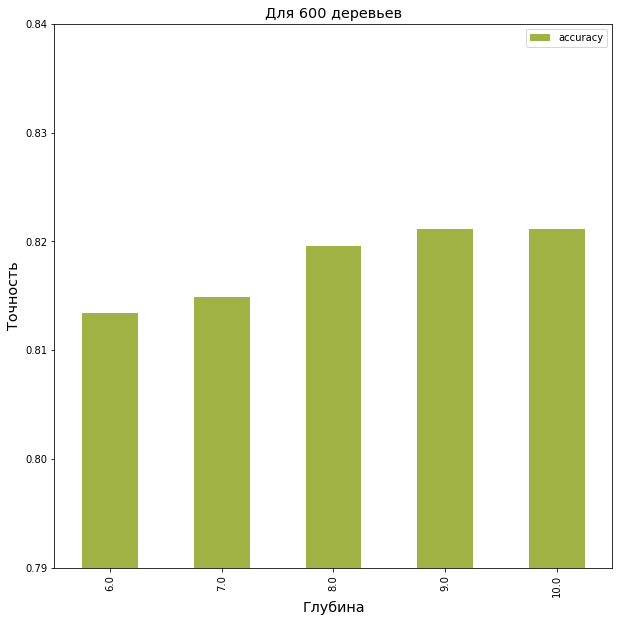

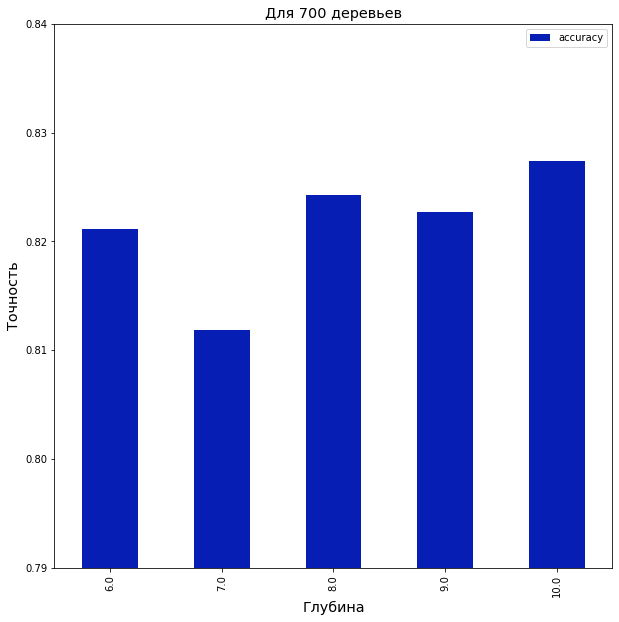

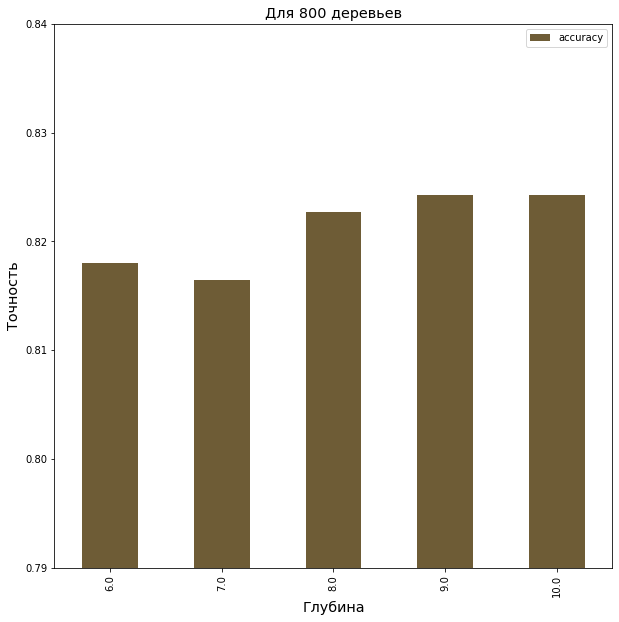

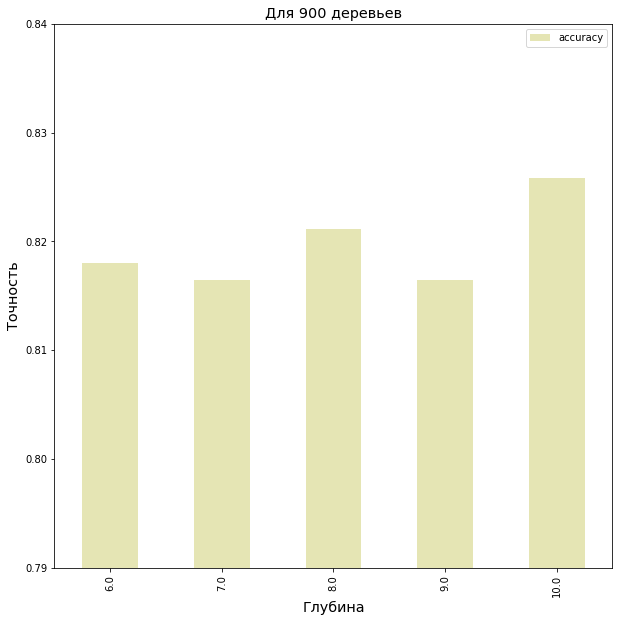

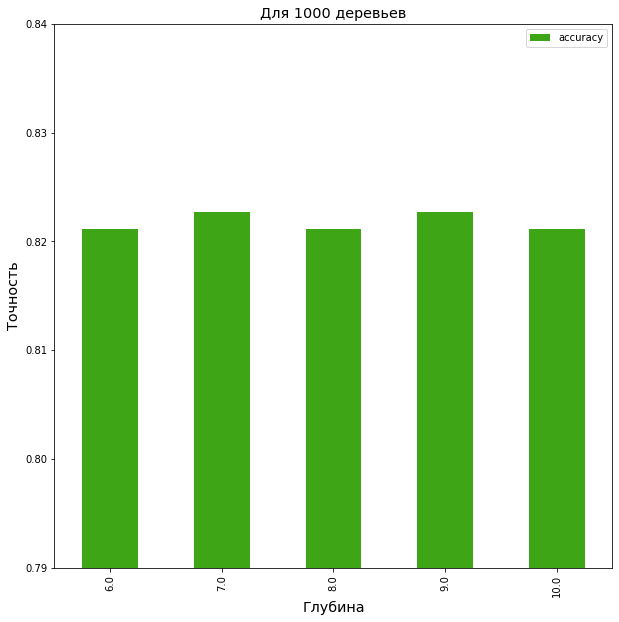

In [27]:
for est in range(100, 1001, 100):
    table_cat
    table_cat[table_cat['iterations'] == est].plot.bar(x='max_depth', 
                                                         y='accuracy', 
                                                         ylim=(0.79, 0.84), 
                                                         figsize=(10,10), 
                                                         color=random_color())
    plt.ylabel('Точность', fontsize='x-large')
    plt.xlabel('Глубина', fontsize='x-large')
    plt.title(f'Для {est} деревьев', fontsize='x-large')
    plt.show()

Максимальная точность получилась:
* при количестве - `100`, `200`, `400`, `700`
* и при их глубине - `7`, `10`, `6`.

При предсказании в тестовой выборке, возьмём тот вариант, где обучение будет проходить быстрее.

Сохраним наш результат:

In [28]:
best_cat = table_cat[table_cat['accuracy'] == table_cat['accuracy'].max()].reset_index()

best_cat['model'] = 'cat boost'

best_cat

,index,iterations,max_depth,accuracy,model
0,1,100.0,7.0,0.827372,cat boost
1,6,200.0,7.0,0.827372,cat boost
2,9,200.0,10.0,0.827372,cat boost
3,15,400.0,6.0,0.827372,cat boost
4,34,700.0,10.0,0.827372,cat boost


### Вывод:

Рассмотрим наши результаты:

In [29]:
# сводная таблица по лучшим моделям

best = pd.DataFrame({'model':[], 'n_estimators':[], 'iterations':[], 'max_depth':[], 'accuracy':[]})

best = best.append(best_tree, ignore_index=True)
best = best.append(best_forest, ignore_index=True)
best = best.append(table_log, ignore_index=True)
best = best.append(best_cat.loc[0], ignore_index=True)

best = best[['model', 'n_estimators', 'iterations', 'max_depth', 'accuracy']]

best

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,model,n_estimators,iterations,max_depth,accuracy
0,decision tree,NaN,NaN,5.0,0.816485
1,random forest,10.0,NaN,8.0,0.832037
2,logistic regression,NaN,NaN,NaN,0.704510
3,cat boost,NaN,100.0,7.0,0.827372


Рассмотрим графики:

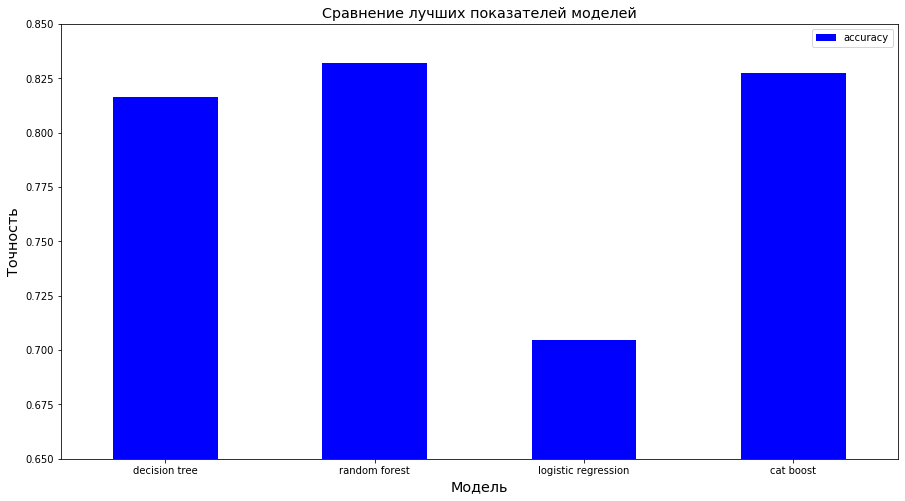

In [30]:
best.plot.bar(x='model', y='accuracy', rot=0, ylim=(0.65, 0.85), figsize=(15,8), color='blue')
plt.title('Сравнение лучших показателей моделей', fontsize='x-large')
plt.xlabel('Модель', fontsize='x-large')
plt.ylabel('Точность', fontsize='x-large')
plt.show()

Лучшие показатели среди моделей:

* Дерево решений - `0.816`
* Случайный лес - `0.832`
* Логистическая регрессия - `0.704`
* Градиентный бустинг - `0.827`

Для соответсвенно, для тестовой выборки возьмём те модели, которые показали значения выше `0.75`

## Проверьте модель на тестовой выборке

Проверим наши модели с лучшими гиперпараметрами на тестовой выборке:

### Дерево решений

Возьмём лучшие гиперпараметры и посмотрим результат точности на тестовой выборке:

In [31]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7) 
model.fit(df_f_train, df_t_train)
predictions_test = model.predict(df_f_test) 
accuracy_tree = accuracy_score(df_t_test, predictions_test) 

**Вывод:**

In [32]:
f'Результат точности дерева решений: {accuracy_tree}'

'Результат точности дерева решений: 0.7822706065318819'

### Случайный лес

Возьмём лучшие гиперпараметры и посмотрим результат точности на тестовой выборке:

In [33]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10)
model.fit(df_f_train, df_t_train)
predictions_test = model.predict(df_f_test)  
accuracy_forest = accuracy_score(df_t_test, predictions_test)  

**Вывод:**

In [34]:
f'Результат точности случайного леса: {accuracy_forest}'

'Результат точности случайного леса: 0.8180404354587869'

### CatBoost (Градиентный бустинг)

Возьмём лучшие гиперпараметры и посмотрим результат точности на тестовой выборке:

In [35]:
# возьмем лучшие гиперпараметры из таблицы

for i in tqdm(range(1,101)):
    model = CatBoostClassifier(random_state=12345, 
                               iterations=best_cat.loc[0, 'iterations'], 
                               max_depth=best_cat.loc[0, 'max_depth'])  
    model.fit(df_f_train, df_t_train, verbose=False) 
    predictions_test = model.predict(df_f_test) 
    accuracy_cat = accuracy_score(df_t_test, predictions_test)

100%|██████████| 100/100 [04:54<00:00,  2.95s/it]


**Вывод:**

In [36]:
f'Результат точности градиентного бустинга: {accuracy_cat}'

'Результат точности градиентного бустинга: 0.8149300155520995'

## Общий вывод:

Создадим отдельную табличку с результатами на тестовой выборке:

In [37]:
# создаём и заполняем таблицу

best_test = pd.DataFrame({'accuracy':[accuracy_tree, accuracy_forest, accuracy_cat]})

best_test['model'] = np.nan
for i in range(0,3):
    models = ['Дерево решений', 'Случайный лес', 'Градиентный бустинг']
    best_test.loc[i, 'model'] = models[i]
    
best_test

,accuracy,model
0,0.782271,Дерево решений
1,0.818040,Случайный лес
2,0.814930,Градиентный бустинг


Построим график результатов:

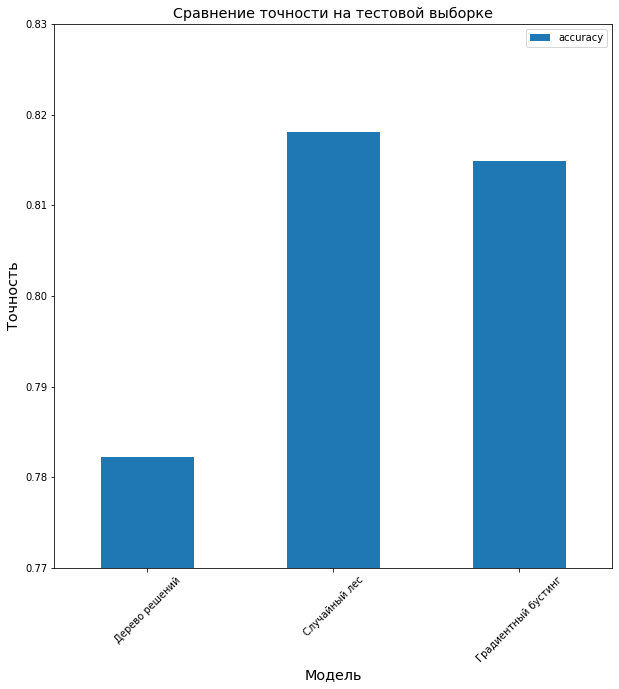

In [38]:
best_test.plot.bar(x='model', ylim=(0.77, 0.83), figsize=(10,10), rot=45)
plt.title('Сравнение точности на тестовой выборке', fontsize='x-large')
plt.xlabel('Модель', fontsize='x-large')
plt.ylabel('Точность', fontsize='x-large')
plt.show()

**На основании полученных результатов:**

Лучшие показатели на тестовой выборке показала модель случайного леса с точностью `0.818040`.

Для предсказаний, стоит пользоваться моделью случайного дерева с параметрами: 
* количество - `50`
* глубина - `10`

## (бонус) Проверьте модели на адекватность

Для проверки адекватности модели мы можем воспользоваться `DummyClassifier`, который всегда предсказывает мажоритарный класс (в данном случае класс **«0»** - `smart`), чтобы проиллюстрировать, насколько малоинформативной может быть правильность:

In [39]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(df_f_train, df_t_train)
pred_most_frequent = dummy_majority.predict(df_f_test)
print("Спрогнозированные метки: {}".format(np.unique(pred_most_frequent)))
print("Правильность на тестовом наборе: {:.2f}".format(dummy_majority.score(df_f_test, df_t_test)))

Спрогнозированные метки: [0]
Правильность на тестовом наборе: 0.69


Дамми-классификатор, который генерирует случайные прогнозы, имеет намного худшее качество (с точки зрения точности). 
Однако даже случайный классификатор дает `69%`-ную правильность. 

Проблема здесь заключается в том, что для несбалансированных наборов данных правильность не является адекватной метрикой, позволяющей количественно оценить прогностическую способность модели.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75